In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

In [2]:
X_train = pd.read_csv('data/X_train_eng.csv', index_col = 'id')
X_test = pd.read_csv('data/X_test_eng.csv', index_col = 'id')
y_train = pd.read_csv('data/y_train_eng.csv', index_col = 'id')
y_test = pd.read_csv('data/y_test_eng.csv', index_col = 'id')

In [3]:
holdout = pd.read_csv('data/holdout_data.csv')

In [4]:
def log_loss(model, X=X_train, y=y_train, scoring='neg_log_loss', cv=3):
    log_loss = cross_val_score(model, X, y, scoring=scoring, cv=cv)
    log_loss = -log_loss.mean()
    print(f'Log loss: {log_loss}')

In [5]:
def model_predictions(model, X=X_test, y=y_test):
    y_pred = model.predict(X)
    cm = confusion_matrix(y_test, y_pred)
    func = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
    func_nr = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
    non_func = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
    print(f'The model correctly predicts {round(func*100, 2)}% of the funtional wells.')
    print(f'The model correctly predicts {round(func_nr*100, 2)}% of the funtional-needs-repair wells.')
    print(f'The model correctly predicts {round(non_func*100, 2)}% of the non-functional wells.')

In [6]:
X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes(['float64', 'int64'])

cat_pipe = Pipeline(steps = [
    ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])
num_pipe = Pipeline(steps = [
    ('imp', SimpleImputer(missing_values=0, strategy='median')),
    ('ss', StandardScaler()),
])

transformer = ColumnTransformer([('categorical', cat_pipe, X_train_cat.columns), 
                                  ('numerical', num_pipe, X_train_num.columns)])

# Using The SVM Model

We are going to use the SVM model with no hyperparameter tuning since it has the best combined score of functional needs repair and non functional wells.

In [7]:
y_train = y_train['status_group']
y_test = y_test['status_group']

In [8]:
svm_pipe = imbPipeline([
    ('trans', transformer), 
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC())
])
svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'public_meeting', 'scheme_management', 'permit',
       'management', 'payment', 'quantity'],
      dtype='object')),
                                                 ('numerical...
                                                                  ('ss',
               

In [9]:
print('Accuracy Score Train:', svm_pipe.score(X_train,y_train))
print('Accuracy Score Test:', svm_pipe.score(X_test,y_test))

Accuracy Score Train: 0.6854111935086961
Accuracy Score Test: 0.6565243415802074


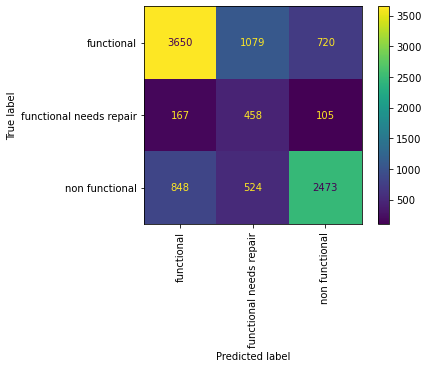

In [10]:
plot_confusion_matrix(svm_pipe, X_test, y_test, xticks_rotation='vertical');

In [11]:
model_predictions(svm_pipe, X_test, y_test)

The model correctly predicts 66.98% of the funtional wells.
The model correctly predicts 62.74% of the funtional-needs-repair wells.
The model correctly predicts 64.32% of the non-functional wells.


# Using Random Forest Model

In [13]:
model_pipe_4 = imbPipeline(steps=[
    ('trans', transformer),
    ('smote', SMOTE(random_state=42)),
    ('rfc', RandomForestClassifier(verbose=1, n_jobs=-2, 
                                   criterion = 'entropy',
                                   max_depth = 80,
                                   min_samples_leaf = 2,
                                   min_samples_split = 2,
                                   n_estimators = 250,
                                   class_weight='balanced'))])

In [14]:
model_pipe_4.fit(X_train, y_train)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-2)]: Done 250 out of 250 | elapsed:    7.2s finished


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'public_meeting', 'scheme_management', 'permit',
       'management', 'payment', 'quantity'],
      dtype='object')),
                                                 ('numerical...
       'population', 'construction_year', 'water_quality_by_region',
       'water_quali

In [15]:
model_pipe_4.score(X_train, y_train)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed:    0.3s finished


0.885437797213262

In [16]:
model_pipe_4.score(X_test, y_test)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed:    0.1s finished


0.7551875498802874

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed:    0.1s finished


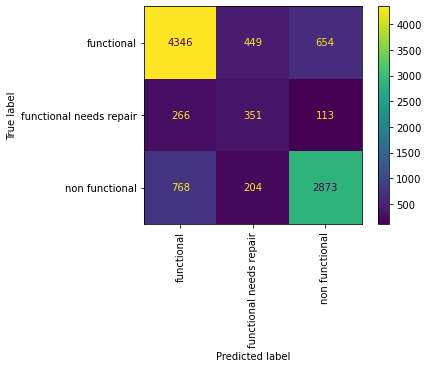

In [17]:
plot_confusion_matrix(model_pipe_4, X_test, y_test, xticks_rotation='vertical');

In [18]:
model_predictions(model_pipe_4, X_test, y_test)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed:    0.1s finished


The model correctly predicts 79.76% of the funtional wells.
The model correctly predicts 48.08% of the funtional-needs-repair wells.
The model correctly predicts 74.72% of the non-functional wells.


# Using the holdout data to see which model is better

In [20]:
holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53460 entries, 0 to 53459
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 53460 non-null  int64  
 1   gps_height         53460 non-null  int64  
 2   installer          53460 non-null  object 
 3   longitude          53460 non-null  float64
 4   latitude           53460 non-null  float64
 5   num_private        53460 non-null  int64  
 6   basin              53460 non-null  object 
 7   region             53460 non-null  object 
 8   region_code        53460 non-null  int64  
 9   district_code      53460 non-null  int64  
 10  population         53460 non-null  int64  
 11  public_meeting     53460 non-null  object 
 12  scheme_management  53460 non-null  object 
 13  permit             53460 non-null  object 
 14  construction_year  53460 non-null  int64  
 15  extraction_type    53460 non-null  object 
 16  management         534